# 6.6 Sourcing and Analyzing Time Series Data

### This script contains the following:

#### 1. Importing your libraries and data
#### 2. Subsetting, wrangling, and cleaning time-series data
#### 3. Create a line chart of the data
#### 4. decompose the data's components
#### 5. Conduct a Dickey-Fuller test
#### 6. If data isn't stationary, conduct a round of differencing on it, and repeat the Dickey-Fuller test
#### 7. Check autocorrelations

### 1. Importing libraries and data

In [105]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [106]:
#create path
path = r'C:\Users\Victoria\Documents\veallen20\OneDrive\Desktop\Data Analytics Career Foundry\6.0 Advanced Analytics and Dashboard Design\Bambino 2.0\02 Data\Cleaned Data'

In [107]:
df = pd.read_csv(os.path.join(path, 'baseball_f.csv'))

### 2. Subsetting, wrangling, and cleaning time-series data

In [108]:
df = df.drop(columns =['Unnamed: 0'])

In [109]:
df.head(5)

,rank,combined_key,name,year,city,state,country,bats,throws,team_signed,...,war,actual_salary,league_r,bats_r,throws_r,team_sr,team_pr,position_r,ts_mil,as_mil
0,1,"Mike Trout, 2019",Mike Trout,2019,"Vineland, New Jersey",New Jersey,United States,R,R,LAA,...,7.9,17666667.0,0,0,0,12,12,8,426.5,17.666667
1,1,"Mike Trout, 2020",Mike Trout,2020,"Vineland, New Jersey",New Jersey,United States,R,R,LAA,...,1.8,37666666.0,0,0,0,12,12,8,426.5,37.666666
2,1,"Mike Trout, 2021",Mike Trout,2021,"Vineland, New Jersey",New Jersey,United States,R,R,LAA,...,1.8,37116667.0,0,0,0,12,12,8,426.5,37.116667
3,1,"Mike Trout, 2022",Mike Trout,2022,"Vineland, New Jersey",New Jersey,United States,R,R,LAA,...,6.3,37116666.0,0,0,0,12,12,8,426.5,37.116666
4,1,"Mike Trout, 2023",Mike Trout,2023,"Vineland, New Jersey",New Jersey,United States,R,R,LAA,...,3.0,37116667.0,0,0,0,12,12,8,426.5,37.116667


In [110]:
df.shape

(1480, 31)

In [111]:
df.columns

Index(['rank', 'combined_key', 'name', 'year', 'city', 'state', 'country',
       'bats', 'throws', 'team_signed', 'team_locale', 'team_locale_county',
       'position', 'contract_start', 'contract_end', 'contract_length',
       'total_salary', 'age', 'team_played', 'league', 'games', 'war',
       'actual_salary', 'league_r', 'bats_r', 'throws_r', 'team_sr', 'team_pr',
       'position_r', 'ts_mil', 'as_mil'],
      dtype='object')

In [112]:
type(df)

pandas.core.frame.DataFrame

In [113]:
# Create subset of avg war, ts_mil, as_mil, contract_length, and games for each year

data = df.groupby('year', as_index=False)[['war', 'games', 'age', 'ts_mil', 'as_mil', 'contract_length']].mean()

In [114]:
data.head()

,year,war,games,age,ts_mil,as_mil,contract_length
0,1997,1.500000,161.000000,30.000000,55.000000,10.000000,5.000000
1,1998,4.300000,56.285714,30.714286,59.185714,6.873095,5.142857
2,1999,4.670000,102.300000,31.500000,70.630000,9.730863,5.800000
3,2000,4.900000,108.076923,31.923077,75.523077,11.426586,6.076923
4,2001,4.805263,96.421053,30.842105,98.015789,12.246283,6.631579


In [115]:
data_sub = data[['year','ts_mil']]

In [121]:
# Set the "Date" column as the index

from datetime import date

data_sub['datetime'] = pd.to_datetime(data_sub['year'], format='%Y') # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['year'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,ts_mil
datetime,
1997-01-01,55.000000
1998-01-01,59.185714
1999-01-01,70.630000
2000-01-01,75.523077
2001-01-01,98.015789


### 3. Create a line chart of the data

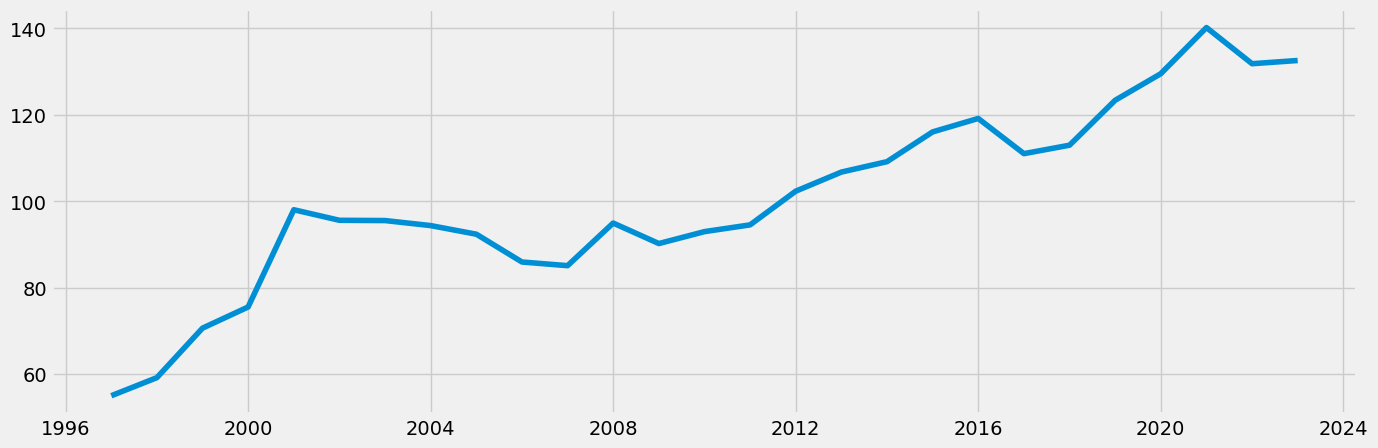

In [123]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

### 4. decompose the data's components

In [124]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [125]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

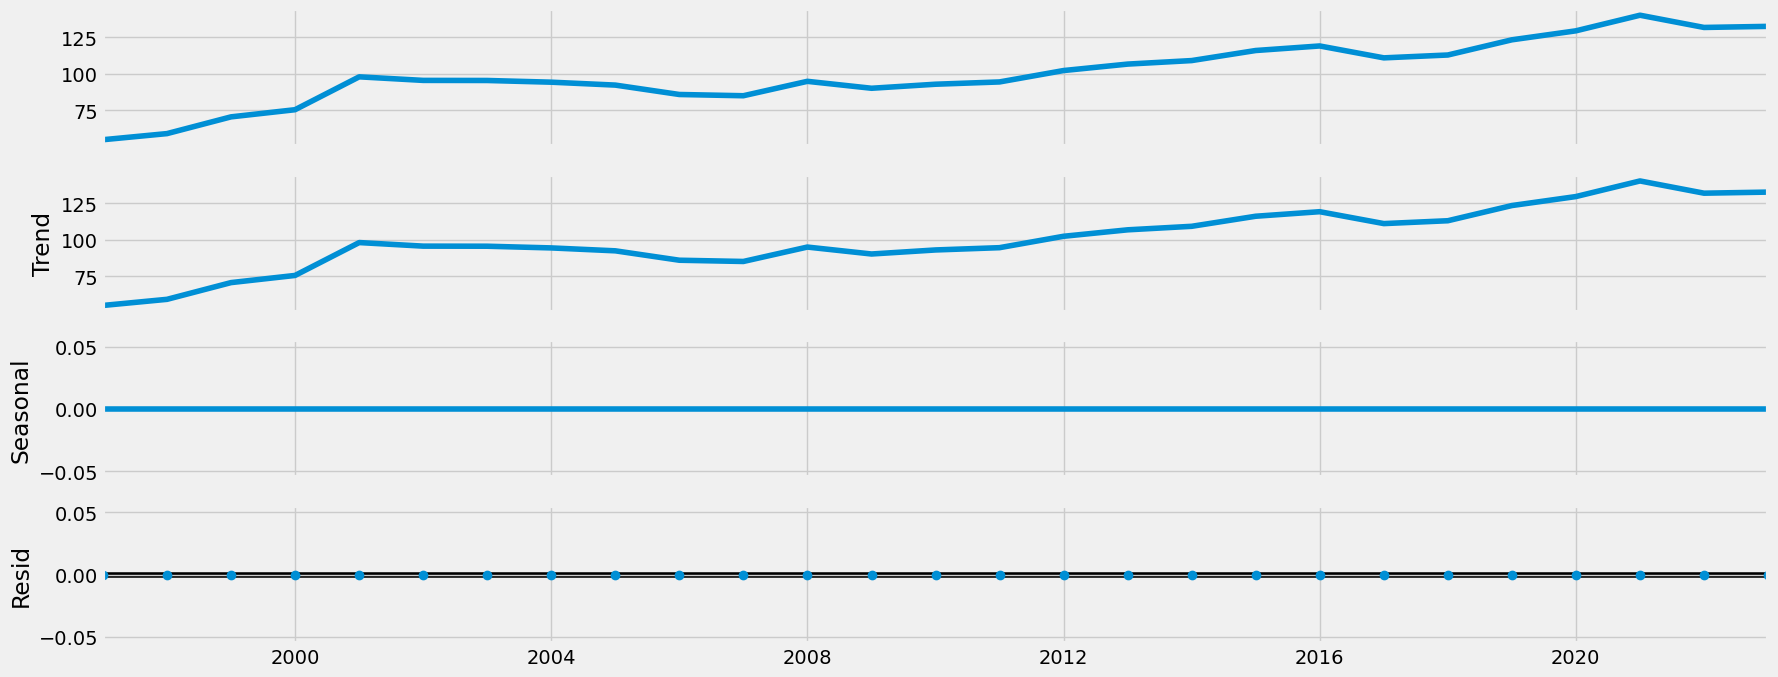

In [126]:
# Plot the separate components

decomposition.plot()
plt.show()

##### Observations
* trend: positive trend with slight variance
* seasonality: no apparent seasonality
* noise: no apparent noise

I would expect this data to be non-stationary because there is a clear upwards trend.

### 5. Conduct a Dickey-Fuller test

In [127]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['ts_mil'])

Dickey-Fuller Stationarity test:
Test Statistic                 -1.627146
p-value                         0.468985
Number of Lags Used             0.000000
Number of Observations Used    26.000000
Critical Value (1%)            -3.711212
Critical Value (5%)            -2.981247
Critical Value (10%)           -2.630095
dtype: float64


##### Observations

test statistic, -1.627 > critical value (5%), -2.98.

The null hypothesis is not rejected meaning that there is a unit root in the data.

The data is non-stationary.

### 6. If data isn't stationary, conduct a round of differencing on it, and repeat the Dickey-Fuller test

In [128]:
#perform differencing
data_diff = data_sub - data_sub.shift(1)

In [129]:
#Remove missing values from differencing so dickey-fuller test can be done again
data_diff.dropna(inplace = True)

In [130]:
data_diff.head()

,ts_mil
datetime,
1998-01-01,4.185714
1999-01-01,11.444286
2000-01-01,4.893077
2001-01-01,22.492713
2002-01-01,-2.443789


In [131]:
data_diff.columns

Index(['ts_mil'], dtype='object')

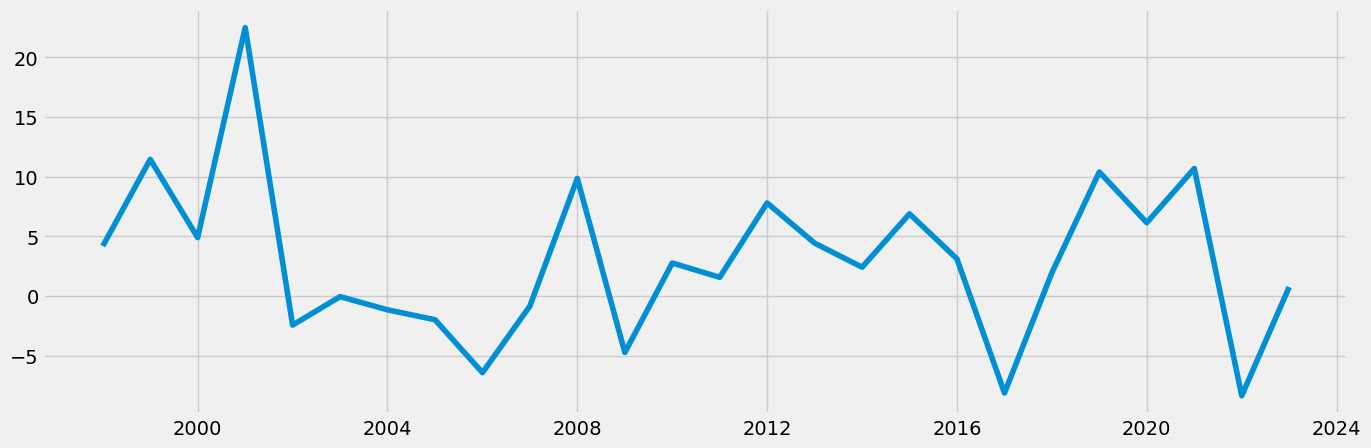

In [132]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

__the plot appears to be more stationary than the original plot.__

__Repeat Dickey-Fuller test__

In [133]:
#run dickey-fuller test again
#can call dickey_fuller as it was defined previously
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -4.793060
p-value                         0.000056
Number of Lags Used             0.000000
Number of Observations Used    25.000000
Critical Value (1%)            -3.723863
Critical Value (5%)            -2.986489
Critical Value (10%)           -2.632800
dtype: float64


##### Observations

test statistic, -4.793 < critical value (5%), -2.986.

The null hypothesis __is__ rejected meaning that there is __not__ a unit root in the data.

This can be determined because the test statistic is less than the critical value (we are working with a significance level of 5%).

The data __is__ stationary.

### 7. Check autocorrelations

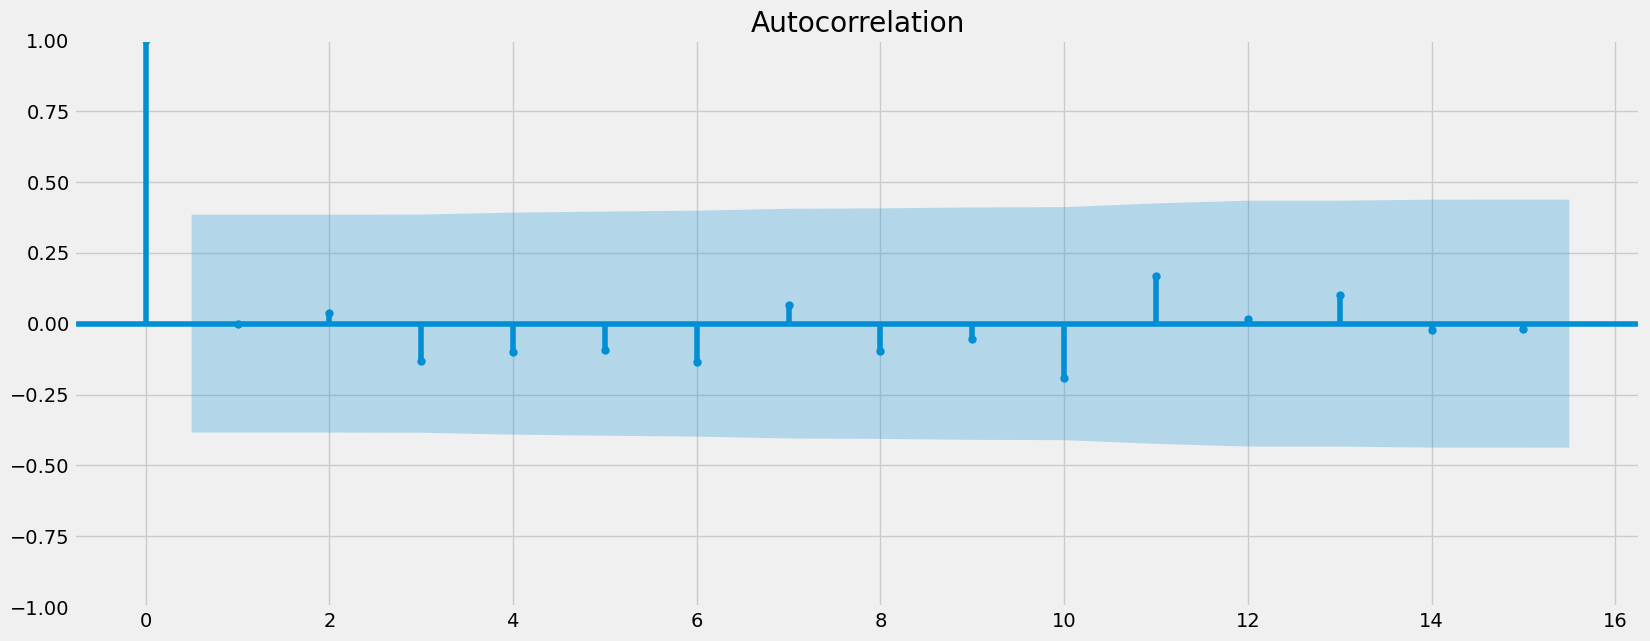

In [134]:
#Create a plot of autocorrelations

# Here, you import the autocorrelation and partial correlation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 

plot_acf(data_diff)
plt.show()

##### Observations:
This plot of autocorrelations shows that the data is indeed stationary and supportst the results from the Dickey-Fuller test. There is only one lag beyond the blue edge of the confidence interval leading me to feel that the stationarity is strong. This is further supported by the p-value from the second Dickey-Fuller test (0.000056) which is much less than the satisfactory p-value (p<0.05).

### Export any useful dataframes

In [136]:
#export 'data'
data.to_csv(os.path.join(path, 'baseball_agg.csv'))